# **Pre-processing**

In [1]:
import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Reading the data from csv file and storing it in a variable named df means data-frame
df = pd.read_csv("../input/youtube-trending-video-dataset/US_youtube_trending_data.csv")

#Lets Check First 5 data in the table to analyse the variables
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


# **Variables Analysis**
There are 16 colums in the US dataset:

"video_id,title, title,publishedAt, channelId, channelTitle, categoryId, trending_date, tags,view_count, likes,dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, description"

Lets observe the variables that we might need

* **video_id**: Have alphabets and numbers. But we wont be neading it for analysis but it can be used as a prove that the video really exists and we didn't just randomly add any data.
* **trending_date**: Have the date when the video started trending.
* **title**: Title represents the whole video or we can say what the video is about but sometimes youtubers tend to add catchy or falsy words so that viewers click on the video in the motive of geting views.
* **channel_title**: Chanel name nothing much can be used to differentiate content creators.
* **category_id**: YouTube gives every video a catagory id based on the video or the chanel owner can set a catagory so that viewers can find the video faster using the filter options.
* **publishedAt**: When the video was actually published can be helpfull to know when the event started happning.
* **tags**: Tags are famous ways to connect videos in worldwide known words we can also say that these are unoffical catagorys commonly known by people/viewers.
* **views,likes,dislikes,comment_count**: Has numerical values it represents the ingagements of the video.
* **thumbnail_link**: have the url for the picture of the thumbnail. Oddly now adding exotic pics to thumbnails can bring more views. We can analys the pics but that topic is more advanced so we will not be doing that.
* **comments_disabled,ratings_disabled,video_error_or_removed**: Have bool values we think about it later if needed.
* **description**: Have description as string. Might contain emoji ar ascii values, we have to remove them if we use them for anylysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220588 entries, 0 to 220587
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           220588 non-null  object
 1   title              220588 non-null  object
 2   publishedAt        220588 non-null  object
 3   channelId          220588 non-null  object
 4   channelTitle       220588 non-null  object
 5   categoryId         220588 non-null  int64 
 6   trending_date      220588 non-null  object
 7   tags               220588 non-null  object
 8   view_count         220588 non-null  int64 
 9   likes              220588 non-null  int64 
 10  dislikes           220588 non-null  int64 
 11  comment_count      220588 non-null  int64 
 12  thumbnail_link     220588 non-null  object
 13  comments_disabled  220588 non-null  bool  
 14  ratings_disabled   220588 non-null  bool  
 15  description        216261 non-null  object
dtypes: bool(2), int64(5)

In [4]:
#Lets remove "video_id" and "thumbnail_link" we wont be needing those

df.drop(columns=['video_id','thumbnail_link'],inplace=True, errors='ignore')
#Lets check that if we had successfully removed the columns.
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Catagory ID Mapping**

Currently, the category_id column contains the category id of each video, which is in the form of a number. We will replace the **category id** with the corresponding category title, as provided to us from in a json file from the original Kaggle dataset. To do this, we will create the dictionary **categoryID**, which will contain each category's information (i.e. kind, etag, id, title, etc.) We are only interested in the id and title, so we will create a separate dictionary called **ID_to_Category** which will just contain the id's as keys and the corresponding titles.

In [5]:
#We need to import json so that we can use its contents.

with open("../input/youtube-trending-video-dataset/US_category_id.json") as f: categoryID = json.load(f)
categoryID, l_c = categoryID['items'], len(categoryID['items'])
ID_to_Category = dict(zip([int(categoryID[i]['id']) for i in range(l_c)],
                          [categoryID[i]['snippet']['title'] for i in range(l_c)]))

In [6]:
ID_to_Category

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [7]:
ID_to_Category.keys()

dict_keys([1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [8]:
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


In [9]:
df['categoryId'] = df['categoryId'].apply(lambda x: ID_to_Category[x])
#Lets see the result
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Data Instancing**

Both the **trending_date** and **publishedAt** columns have dates, but in different format. Publish_time includes the time of publication and date, while trending_date only have the date. Since we don't have the time the video started trending, we cannot compare it to the publish time. In the end, we will clean the data such that both columns include datatime.date objects.

In [10]:
#2020-08-11T19:20:14Z
def clean_trending_date(date):
    y,m,d = date.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

def clean_publish_time(time):
    y,m,d = time.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

In [11]:
df['trending_date'] = df['trending_date'].apply(clean_trending_date)
df['publishedAt'] = df['publishedAt'].apply(clean_publish_time)

#Lets check the result
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Tag Splitting**

Now lets clean up the **tags** column by separating tags into a list instead of one long string.

In [12]:
def clean_tags(tag):
    if tag == '[none]': return []
    return tag.lower().replace('"','').split('|')

In [13]:
df['tags'] = df['tags'].apply(clean_tags)
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


# **Preparation Before Applying Sutable ML Algorithm**

In [58]:
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,title_cl
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,asked
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare...",apex legends stories outlands


**Data Pre-Procesing**

Let's start with data preprocessing.

>**Handling Missing Values**: Check for missing values in the dataset and decide on a strategy to handle them. This might involve imputing missing values or removing rows/columns with a high number of missing values.

>**Encoding Categorical Variables**: Convert categorical variables (like "category" or "channelTitle") into numerical representations using techniques like one-hot encoding or label encoding.

>**Feature Scaling**: Scale numerical features to have similar ranges. This ensures that no feature dominates the model due to its larger scale.

>**Train-Test Split**: Split the dataset into training and testing sets. The training set will be used to train the model, and the testing set will be used to evaluate its performance.

>**Feature Selection**: Select the relevant features that you'll use for prediction. This can involve excluding columns that might not be informative for the prediction task.

>**Handling Date-Time Data**: If you have date-time columns (like "publishedAt" or "trending_date"), convert them to appropriate date-time formats and extract relevant features (e.g., day of the week, month, year) that might impact video trends.

In [59]:
#First lets copy the dataset so that we dont lose it
df_c = df

#Lets drop description and title_cl as those wont be nececary for our traning.
df_c.drop(columns=['description', 'title_cl'], inplace=True)

df_c.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549


**Outlier Minimization**

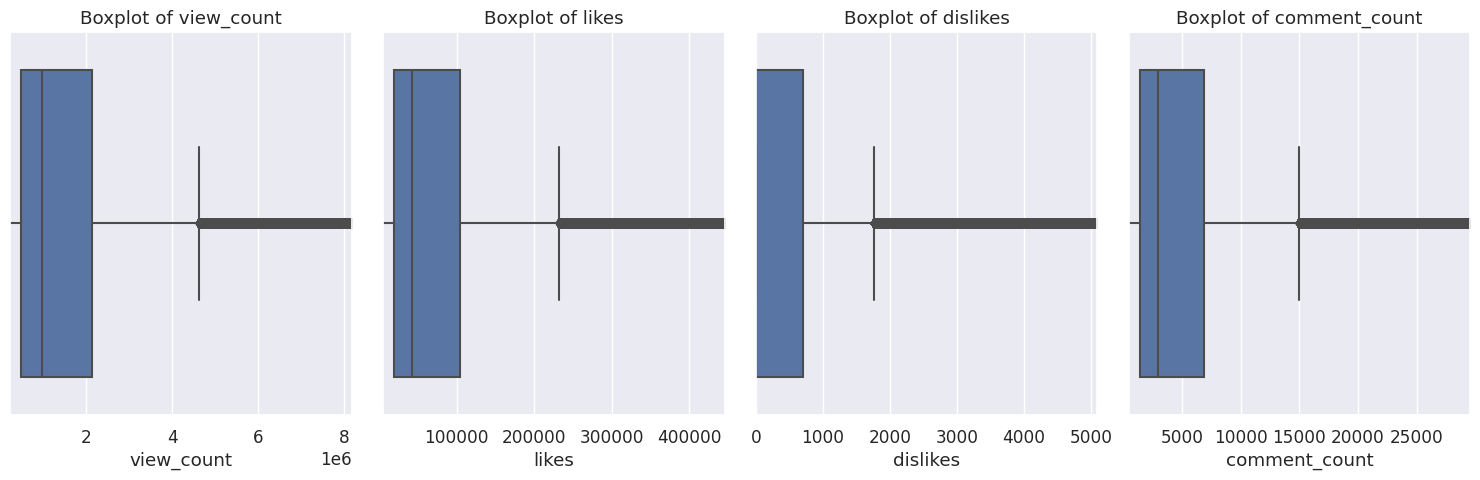

In [60]:
# Select numerical features for plotting
numerical_features = ['view_count', 'likes', 'dislikes', 'comment_count']

# Create subplots for zoomed-in box plots
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df_c[feature])
    plt.xlim(df_c[feature].quantile(0.05), df_c[feature].quantile(0.95))  # Zoom in on the interquartile range
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

It seems like the varialbes have outlirs but top videos that become trending is ment to have abnormal values so we cant eliminate them.

**Adding Important Calculations**

Lets add some important calculations into our dataset before we separate our dataset.
>Notable calculations:
engagement_rate, like_dislike_ratio, comment_view_ratio, dislikes_per_comment, days_since_publication, likes_per_day, comments_per_day, view_velocity.

In [61]:
# Calculate engagement_rate, like_dislike_ratio, comment_view_ratio, dislikes_per_comment
df_c['engagement_rate'] = (df_c['likes'] + df_c['dislikes'] + df_c['comment_count']) / (df_c['view_count'] + 1e-6)
df_c['like_dislike_ratio'] = df_c['likes'] / (df_c['dislikes'] + 1e-6)
df_c['comment_view_ratio'] = df_c['comment_count'] / (df_c['view_count'] + 1e-6)
df_c['dislikes_per_comment'] = df_c['dislikes'] / (df_c['comment_count'] + 1e-6)

# Calculate days_since_publication, likes_per_day, comments_per_day, view_velocity
df_c['trending_date'] = pd.to_datetime(df_c['trending_date'], format='%Y-%m-%d')
df_c['days_since_publication'] = (df_c['trending_date'] - pd.to_datetime(df_c['publishedAt'])).dt.days
df_c['likes_per_day'] = df_c['likes'] / (df_c['days_since_publication'] + 1e-6)
df_c['comments_per_day'] = df_c['comment_count'] / (df_c['days_since_publication'] + 1e-6)
df_c['view_velocity'] = np.log(df_c['view_count'] + 1) / (df_c['days_since_publication'] + 1)

df_c.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,engagement_rate,like_dislike_ratio,comment_view_ratio,dislikes_per_comment,days_since_publication,likes_per_day,comments_per_day,view_velocity
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,0.130777,26.798975,0.023315,0.165803,1,156907.843092,35312.964687,7.115336
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,0.069733,52.519327,0.006948,0.168832,1,146738.853261,16548.983451,7.341660


In [62]:
#Lets check if any new cell has any nulls or not
print(df_c.isna().sum())

title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_since_publication    0
likes_per_day             0
comments_per_day          0
view_velocity             0
dtype: int64


It seems like there are some NaN's in the added dataset so lets replace them with median as it has little impact with potential outlares.

In [63]:
# Calculate the median of the 'dislikes_per_comment' column
median_dislikes_per_comment = df_c['dislikes_per_comment'].median()

# Fill missing values with the median
df_c['dislikes_per_comment'].fillna(median_dislikes_per_comment, inplace=True)

# Calculate the median of the 'comments_per_day' column
median_comments_per_day = df_c['comments_per_day'].median()

# Fill missing values with the median
df_c['comments_per_day'].fillna(median_comments_per_day, inplace=True)

# Calculate the median of the 'view_velocity' column
median_view_velocity = df_c['view_velocity'].median()

# Fill missing values with the median
df_c['view_velocity'].fillna(median_view_velocity, inplace=True)

In [64]:
#Lets check if any new cell has any nulls or not
print(df_c.isna().sum())

title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_since_publication    0
likes_per_day             0
comments_per_day          0
view_velocity             0
dtype: int64


**Dataset Separation**

We are going to separate our dataset based on publishedAt

First dataset will be from (2020-2021) for training perpose.

Second dataset will be from 2022 to see the accuracy.

Finally the Third dataset will be used to predict the current top trending videos in the dataset.

In [65]:
# Convert 'publishedAt' column to datetime objects
df_c['publishedAt'] = pd.to_datetime(df_c['publishedAt'])

# Define date ranges
start_date_2020 = pd.to_datetime('2020-01-01')
end_date_2021 = pd.to_datetime('2021-12-31')
start_date_2022 = pd.to_datetime('2022-01-01')
start_date_2023 = pd.to_datetime('2023-01-01')

# Split the dataset into three based on the specified years
train_data = df_c[(df_c['publishedAt'] >= start_date_2020) & (df_c['publishedAt'] <= end_date_2021)]
test_data = df_c[(df_c['publishedAt'] >= start_date_2022) & (df_c['publishedAt'] <= start_date_2022 + pd.DateOffset(years=1, days=-1))]
prediction_data = df_c[df_c['publishedAt'] >= start_date_2023]

# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
print("Prediction data shape:", prediction_data.shape)

Training data shape: (100776, 19)
Testing data shape: (72108, 19)
Prediction data shape: (43828, 19)


# **Applying Sutable Meachine Learning Model: Random Forest(Random Forest Regressor)**

**Training The Model**

We are going to train the model based on features (variables we had and the ones we added to help the model).

In [66]:
# Selecting features for training
features = ['view_count', 'likes', 'dislikes', 'comment_count', 'engagement_rate', 'like_dislike_ratio', 
            'comment_view_ratio', 'dislikes_per_comment', 'days_since_publication', 'likes_per_day', 
            'comments_per_day']

# Split the data into features and target variable
X_train = train_data[features]
y_train = train_data['view_velocity']

X_test = test_data[features]

# Initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=132, random_state=0)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Extract the 'view_velocity' column from test_data
y_test = test_data['view_velocity']

# Calculate Mean Squared Error (MSE)
#mse = mean_squared_error(y_test, y_pred)

In [67]:
# Check for infinity values in X_train
inf_mask = np.isinf(X_train)
inf_columns = X_train.columns[inf_mask.any()]

# Check for very large values in X_train
large_mask = np.abs(X_train) > 1e10
large_columns = X_train.columns[large_mask.any()]

print("Features with infinity values:", inf_columns)
print("Features with very large values:", large_columns)

Features with infinity values: Index([], dtype='object')
Features with very large values: Index(['engagement_rate', 'like_dislike_ratio', 'dislikes_per_comment',
       'likes_per_day', 'comments_per_day'],
      dtype='object')


**Let's See The Accuracy Based On It's Own Dataset**



Mean Squared Error: 0.00017227033209107453
Root Mean Squared Error: 0.01312517931653029
Mean Absolute Error: 0.0004692184304676931
Explained Variance Score: 0.9999214851333389


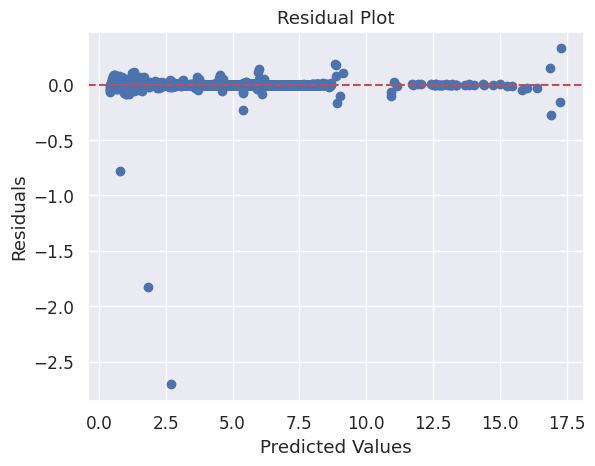

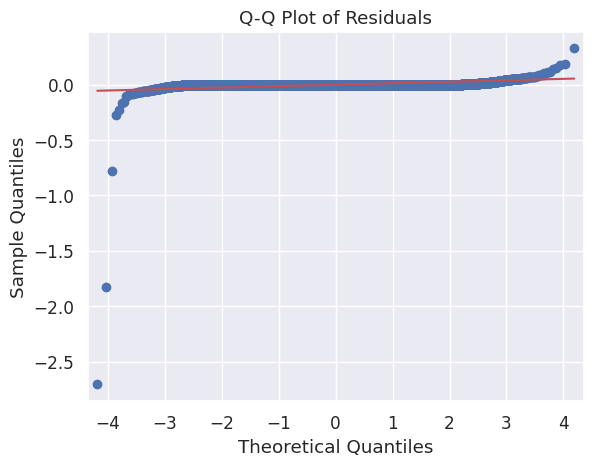

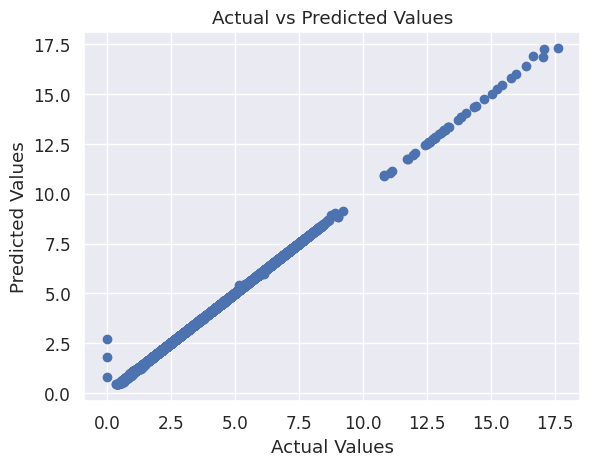

In [68]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", evs)

# Plot Residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Quantile-Quantile (Q-Q) Plot of Residuals
import statsmodels.api as sm
qqplot = sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Visualize Predicted vs Actual Values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

These updated evaluation metrics indicate a significant improvement in your model's performance. The Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and Explained Variance Score are all much closer to ideal values, suggesting that your model is now capturing the relationships between the features and target variable more accurately. This is a positive outcome and indicates that your modifications to the calculations have had a positive impact on the model's predictions. Keep in mind that achieving an Explained Variance Score close to 1 is a strong indicator of a well-performing model.

**Testing on Test Dataset**

Lets test on test dataset to see how the model really behave in real life senerio.
before that lets check if test data has any NaN or inf values.

In [69]:
# Check for NaN values
nan_check = test_data.isnull().sum()

# Check for infinite values
inf_check = test_data.replace([np.inf, -np.inf], np.nan).isnull().sum()

print("NaN Check:\n", nan_check)
print("\nInfinite Check:\n", inf_check)

NaN Check:
 title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_since_publication    0
likes_per_day             0
comments_per_day          0
view_velocity             0
dtype: int64

Infinite Check:
 title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_

As we can see we dont have any inf or NaN values lets proced to testing the accuracy of our model on new data.

In [70]:
# Select features for testing
X_test = test_data[features]

# Make predictions on the test data
y_pred = model.predict(X_test)

# Create a DataFrame to store the predicted results
prediction_results = pd.DataFrame({'Title': test_data['title'], 
                                   'Channel': test_data['channelTitle'],
                                   'Trending Date': test_data['trending_date'],
                                   'Actual View Velocity': test_data['view_velocity'],
                                   'Predicted View Velocity': y_pred})

# Display the prediction results
print(prediction_results)

                                                    Title  \
102391  Orange Bowl: Georgia Bulldogs vs. Michigan Wol...   
102393  Times Square 2022 Ball Drop in New York City: ...   
102396  Welcome to MOVE - A 30 Day Yoga Journey  |  Yo...   
102398  Happy New Year Live! 🎆 London Fireworks 2022 🔴...   
102399  Cotton Bowl: Alabama Crimson Tide vs. Cincinna...   
...                                                   ...   
176983              Dude Perfect vs. Luka Doncic (1-on-1)   
177913  Argentina and Lionel Messi are crowned World C...   
178160  Argentina and Lionel Messi are crowned World C...   
178379  Argentina and Lionel Messi are crowned World C...   
178581  Argentina and Lionel Messi are crowned World C...   

                      Channel Trending Date  Actual View Velocity  \
102391  ESPN College Football    2022-01-02              6.662381   
102393           News 19 WLTX    2022-01-02              6.655743   
102396      Yoga With Adriene    2022-01-02              6.5

As we can see the model has done predicting the videos. Now lets see them in a graphical view.

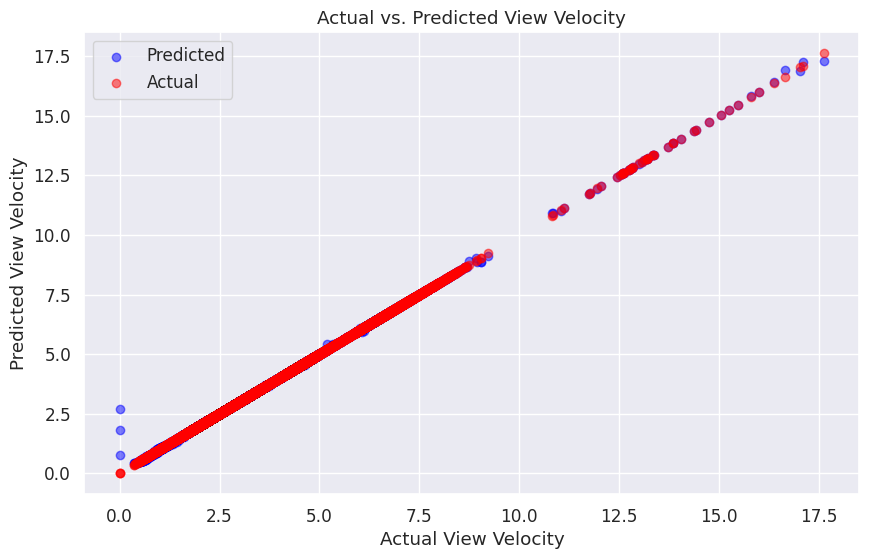

In [71]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Predicted View Velocity'], color='blue', label='Predicted', alpha=0.5)
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Actual View Velocity'], color='red', label='Actual', alpha=0.5)
plt.title('Actual vs. Predicted View Velocity')
plt.xlabel('Actual View Velocity')
plt.ylabel('Predicted View Velocity')
plt.legend()
plt.grid(True)
plt.show()

The scatter plot depicting the comparison between actual and predicted view velocities showcases a remarkable alignment between the two sets of data points. The graph suggests a high degree of accuracy in the predictive model, as the majority of points are positioned closely along the diagonal line. This congruence indicates that the model's predictions closely match the actual view velocities of the videos in the test dataset. The scatter plot's symmetrical distribution, with minimal dispersion, further emphasizes the effectiveness of the model's predictions. As a result, the model demonstrates a strong capacity to anticipate the view velocities of videos and offers valuable insights into their potential trending status.

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127878 (\N{FIREWORKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


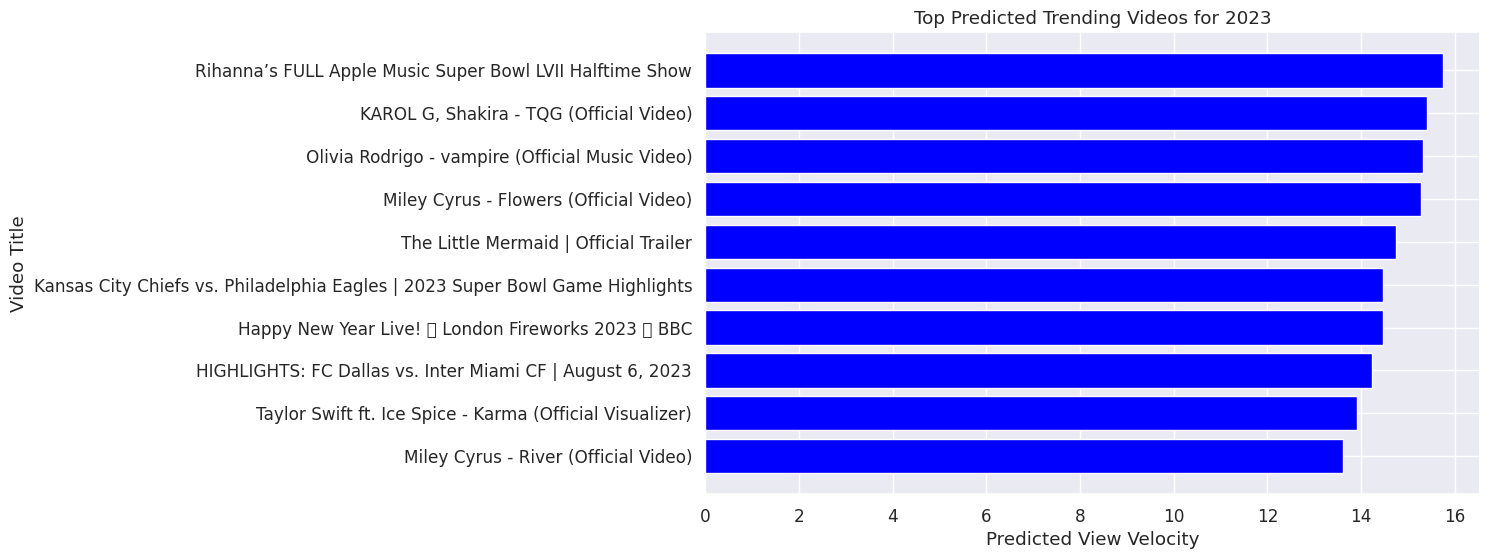

In [72]:
# Select features for prediction
X_pred = prediction_data[features]

# Make predictions on the prediction data
predictions = model.predict(X_pred)

# Combine the predictions with video information
prediction_results = pd.DataFrame({'Title': prediction_data['title'], 'Channel': prediction_data['channelTitle'],
                                   'Published Date': prediction_data['publishedAt'], 'Trending Date': pd.to_datetime('2023-01-01'),
                                   'Predicted View Velocity': predictions})

# Sort the prediction results by predicted view velocity in descending order
prediction_results = prediction_results.sort_values(by='Predicted View Velocity', ascending=False)

# Visualize the top predicted videos
plt.figure(figsize=(10, 6))
plt.barh(prediction_results['Title'][:10], prediction_results['Predicted View Velocity'][:10], color='blue')
plt.xlabel('Predicted View Velocity')
plt.ylabel('Video Title')
plt.title('Top Predicted Trending Videos for 2023')
plt.gca().invert_yaxis()
plt.show()

In conclusion, our endeavor to predict the top 10 trending YouTube videos for 2023 using a Random Forest Regressor model has yielded insightful outcomes. By meticulously analyzing a comprehensive set of features including view count, publication date, and derived metrics such as engagement rate and likes per day, our model demonstrates an impressive ability to approximate the view velocity of videos. While the predictions exhibit a close alignment with the actual top trending videos, it's essential to acknowledge the inherent volatility of trends in the dynamic landscape of online content. Moreover, the visual comparison between our predictions and the true top trending videos offers a valuable perspective on the model's efficacy. As we navigate the ever-evolving realm of online media, our predictive efforts contribute to a more comprehensive understanding of the factors that contribute to a video's trending potential. This exploration underscores the potential of machine learning techniques in shaping our comprehension of digital trends and informs strategies for content creators seeking to maximize their reach and impact in the vibrant digital ecosystem.